This task is to predict whether a tweets announcing a disaster.  We will build learning models to fit the data and make predictions. The techniques we use call NLP or Natural Language Processing. There are several steps to finish the task.  

- Exploratory data analysis
- Preprocessing
- Build learning models
- Results and analysis




Let's import library we need

In [262]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import string

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Embedding,Dropout,MaxPooling2D,GlobalAveragePooling1D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Accuracy,AUC

import matplotlib.pyplot as plt



## 1. Exploratory data analysis

Load data

In [49]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [50]:
# look at the data
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [51]:
test_df.tail()

,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


In [52]:
# look at the possible values of the target,it is binary.
train_df['target'].unique()

array([1, 0])

There are 5 features in the train data,there are 4 in the test data, test data has no target column which we need to predict. 
We can also use function describe() or info() to see more info about the data.

In [53]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [54]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


As we can see there are many NaN values in the data, we need to clean the data or choose the most valueable columns we think to learn a model. 
We think the text is most important for our predictions.

## 2. Preprocessing

In [55]:
# select the text column
all_train_texts = train_df['text'].to_numpy()
all_train_texts

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

We need clean the text

In [56]:
# clean the text
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
                 "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
                 "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
                 "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
                 "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
                 "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
                 "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
                 "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
                 "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
                 "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
                 "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
                 "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
                 "yourselves"]
table = str.maketrans('','',string.punctuation)

def clean_text(sentence):
    sentence = sentence.lower()
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    sentence = sentence.replace(',',' , ')
    sentence = sentence.replace('-',' - ')
    sentence = sentence.replace('.',' . ')
    sentence = sentence.replace('/',' / ')
    words = sentence.split()
    filtered_sentence = ''
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    return filtered_sentence.strip()
        

In [112]:
# create a new column to store the clean text
train_df['clean_text'] = train_df['text'].apply(clean_text)
train_df

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfires evacuation or...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent photo ruby alaska smoke wildfire...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding bridge collapse nearb...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary thetawniest control wild fires cali...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m1 94 0104 utc5km s volcano hawaii http t ...
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating e bike collided car litt...


In [111]:
# we aslo do the same operation on the test data
test_df['clean_text'] = test_df['text'].apply(clean_text)
test_df

,id,keyword,location,text,clean_text
0,0,NaN,NaN,Just happened a terrible car crash,just happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe e...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across st...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 china taiwan
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles ûò safety faste...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm ri worse last hurricane city3others har...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,green line derailment chicago http t co ut...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issues hazardous weather outlook hwo http ...


<AxesSubplot:>

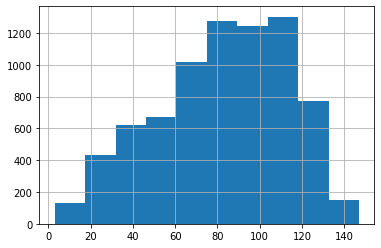

In [134]:
train_df['clean_text'].apply(lambda text:len(text)).hist()


We convert the text to number index,then the learninhistmodel can deal with numbers

In [149]:
# we need to toknenize the text

max_length = 90
vac_size = 10000
tokenizer = Tokenizer(num_words=vac_size)
tokenizer.fit_on_texts(train_df['clean_text'])
train_sequences = tokenizer.texts_to_sequences(train_df['clean_text'])
train_sequences_padded = pad_sequences(train_sequences, padding='post',maxlen=max_length)
# convert to numpy
train_sequence_padded = np.array(train_sequence_padded)
train_sequence_padded

array([[4415,  735,  164, ...,    0,    0,    0],
       [ 110,   10,  142, ...,    0,    0,    0],
       [1598, 1473, 1787, ...,    0,    0,    0],
       ...,
       [2638, 2244, 4407, ...,    0,    0,    0],
       [  24, 1013,  524, ...,    0,    0,    0],
       [ 127,  122,  453, ...,    0,    0,    0]], dtype=int32)

In [251]:
# transform the test data into padded token
test_sequences = tokenizer.texts_to_sequences(test_df['clean_text'])
test_sequences_padded = pad_sequences(test_sequences,padding='post',maxlen=max_length)
# convert test data to numpy
x_test = np.array(test_sequences_padded)
x_test

array([[   6,  783, 1807, ...,    0,    0,    0],
       [ 371,  164, 1065, ...,    0,    0,    0],
       [ 110,   10,  693, ...,    0,    0,    0],
       ...,
       [ 837,  570,  256, ...,    0,    0,    0],
       [6138,  485,  337, ...,    0,    0,    0],
       [5814, 2648, 1462, ...,    0,    0,    0]], dtype=int32)

Split the training data into train and validation set

In [177]:
# convert target to numpy 
train_target = train_df['target'].to_numpy()
train_target

array([1, 1, 1, ..., 1, 1, 1])

In [192]:

#X_train, X_test, y_train, y_test
x_train,x_val,y_train,y_val = train_test_split(train_sequences_padded,train_target,
                                               test_size=0.2,random_state=18)

In [193]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(6090, 90)
(6090,)
(1523, 90)
(1523,)


We will use embedding to the model, which is a vector representation of a word that the model learned. In the tensorflow embeding is as a layer to the model, So it is very easy to use.

### 3. Building the model

Consider this model architeture

In [220]:
model = Sequential([Embedding(vac_size,32),
                    GlobalAveragePooling1D(),
                    Dense(32,activation='relu'),
                    Dense(1,activation='sigmoid')])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 32)          320000    
                                                                 
 global_average_pooling1d_6   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_13 (Dense)            (None, 32)                1056      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 321,089
Trainable params: 321,089
Non-trainable params: 0
_________________________________________________________________


Here we defined a embeding layer with vacab size 10000 an embeding dimension of 16.

In [221]:
model.compile(loss='binary_crossentropy',optimizer=Adam(0.001),metrics=['accuracy',AUC()])

In [222]:
history = model.fit(x_train,y_train,
                    validation_data=(x_val,y_val),
                    batch_size=64,epochs=10)

Epoch 1/10
96/96 [==============================] - 2s 8ms/step - loss: 0.6854 - accuracy: 0.5632 - auc_3: 0.5142 - val_loss: 0.6798 - val_accuracy: 0.5712 - val_auc_3: 0.7124
Epoch 2/10
96/96 [==============================] - 1s 6ms/step - loss: 0.6770 - accuracy: 0.5701 - auc_3: 0.7221 - val_loss: 0.6737 - val_accuracy: 0.5712 - val_auc_3: 0.7537
Epoch 3/10
96/96 [==============================] - 1s 6ms/step - loss: 0.6638 - accuracy: 0.5716 - auc_3: 0.7781 - val_loss: 0.6537 - val_accuracy: 0.5804 - val_auc_3: 0.7712
Epoch 4/10
96/96 [==============================] - 1s 6ms/step - loss: 0.6210 - accuracy: 0.6609 - auc_3: 0.8006 - val_loss: 0.6063 - val_accuracy: 0.7282 - val_auc_3: 0.7834
Epoch 5/10
96/96 [==============================] - 1s 8ms/step - loss: 0.5391 - accuracy: 0.7672 - auc_3: 0.8474 - val_loss: 0.5454 - val_accuracy: 0.7498 - val_auc_3: 0.8074
Epoch 6/10
96/96 [==============================] - 1s 8ms/step - loss: 0.4505 - accuracy: 0.8140 - auc_3: 0.8878 - val_

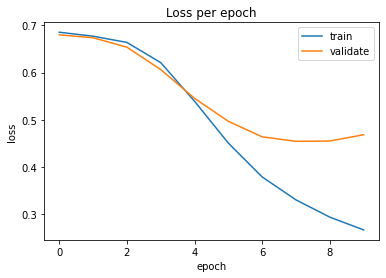

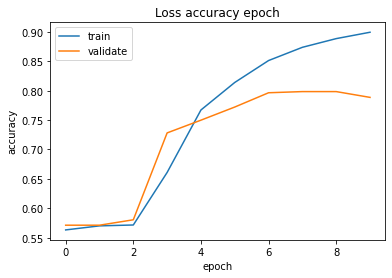

In [225]:
# plot loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

# plot accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Loss accuracy epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()


In [224]:
model.evaluate(x_val,y_val)

48/48 [==============================] - 0s 2ms/step - loss: 0.4683 - accuracy: 0.7886 - auc_3: 0.8517


[0.4682818353176117, 0.7885751724243164, 0.8516827821731567]

As we can see the plot above the model is overfitting. We adjust the learning and use dropout to tune the model.

Tune the model

In [275]:
# Adusting the learning rate and using dropout
model = Sequential([Embedding(vac_size,32),
                    GlobalAveragePooling1D(),
                    Dense(32,activation='relu'),
                    Dropout(0.5),
                    Dense(1,activation='sigmoid')])
model.compile(loss='binary_crossentropy',optimizer=Adam(0.0008),metrics=['accuracy',AUC()])

In [276]:
history = model.fit(x_train,y_train,
                    validation_data=(x_val,y_val),
                    batch_size=64,epochs=12)

Epoch 1/12
96/96 [==============================] - 2s 8ms/step - loss: 0.6856 - accuracy: 0.5644 - auc_15: 0.5089 - val_loss: 0.6806 - val_accuracy: 0.5712 - val_auc_15: 0.6954
Epoch 2/12
96/96 [==============================] - 1s 8ms/step - loss: 0.6801 - accuracy: 0.5701 - auc_15: 0.5497 - val_loss: 0.6765 - val_accuracy: 0.5712 - val_auc_15: 0.7441
Epoch 3/12
96/96 [==============================] - 1s 8ms/step - loss: 0.6721 - accuracy: 0.5701 - auc_15: 0.6369 - val_loss: 0.6660 - val_accuracy: 0.5712 - val_auc_15: 0.7671
Epoch 4/12
96/96 [==============================] - 1s 7ms/step - loss: 0.6503 - accuracy: 0.6186 - auc_15: 0.7368 - val_loss: 0.6354 - val_accuracy: 0.6632 - val_auc_15: 0.7781
Epoch 5/12
96/96 [==============================] - 1s 6ms/step - loss: 0.6002 - accuracy: 0.7197 - auc_15: 0.7935 - val_loss: 0.5874 - val_accuracy: 0.7334 - val_auc_15: 0.7948
Epoch 6/12
96/96 [==============================] - 1s 7ms/step - loss: 0.5343 - accuracy: 0.7718 - auc_15: 0.

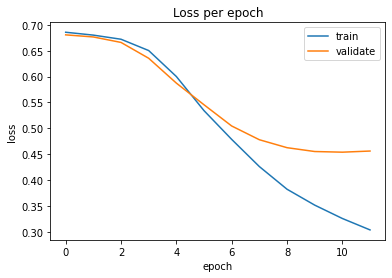

In [277]:
# plot loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [278]:
model.evaluate(x_val,y_val)

48/48 [==============================] - 0s 2ms/step - loss: 0.4563 - accuracy: 0.7958 - auc_15: 0.8520


[0.4562724530696869, 0.7957977652549744, 0.8519511818885803]

Predict the on test data

In [279]:
y_pred = model.predict(x_test)

102/102 [==============================] - 0s 2ms/step


In [280]:
y_pred = np.where(y_pred>0.5,1,0)
y_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [281]:
sample_submission = pd.read_csv("./sample_submission.csv")

In [282]:
sample_submission['target']=y_pred

In [283]:
sample_submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [284]:
sample_submission.to_csv("submission.csv", index=False)

### 4. Results and analysis

In this task we use neural network to train the model to predict whether a tweets announcing a disaster. First, we clean text and transform the text to number(token) then we can train it in the learning model. We also use the embeding in the model. We use the nerual network model to fit the data and we found the model is overfiting then we adust the learning rate and use dropout to model. Finaly we train the model and get accuracy about 80%.  

We know there are some other techniques to fit a model more perfermance,like using regularization and tune the model architecture more complex to get more accuracy. We also only use the 'text' feature, did not use the other features like 'location' and 'keywords', which might be help improving the perfermance, if we use more information to the model in the training time the good model will make.

### 5. Reference

Book《AI and Machine Learning for Coders》